# generate synthetic data to check statistical laws derived about moving averages, demodulation, etc ...

Notes:

- check with Zoe about normalization
- detrending induces oscillations in autocorrelations
- large noise for each decorrelation function ... need to check litterature about decorrelation estimates?


In [1]:
import xarray as xr
import numpy as np
from scipy import signal
import dask

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(28*1)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:58861 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


---

In [31]:
# generate an ensemble of random time series from prescribed spectral shapes

def stochastic(T, x_rms, noise, dt=None):
    """ First order stochastic equation, from Lacasce 2008, equation 25
    """
    x = np.zeros_like(noise)
    for i in range(1, x.shape[-1]):
        x[...,i] = (x[...,i-1] 
                    - dt/T[...,i] * x[...,i-1]
                    + np.sqrt(2*dt/T[...,i])*x_rms[...,i]*noise[...,i]
                   )
    return x

def random_slow(T, 
                Tcut,
                dt=1/24.,
                time=None,
                rms=1.,
                N=100,
                chunks=None,
               ):
    """ Generate an ensemble of random time series from prescribed spectral shapes
    
    Parameters
    ----------
        T: float
            Length of the time series
        Tcut: float, iterable
            Cutoff time period
        dt: float, optional
            time step, default is 1/24
        time: ndarray
            time series
        rms: float, iterable, optional
            Final rms, default to 1.
        N: int, optional
            Number of ensemble time series to build.
            Default to 100
        chunks: dict, optional
            time series dask chunks, default is 'auto'
    """
    if time is None:
        time = np.arange(0., T, dt)
    Nt = time.size
        
    Tcut = np.array(Tcut, ndmin=1)            
    rms = np.array(rms, ndmin=1)

    dims = ['Tcut', 'rms', 'draw', 'time']
    _size = (Tcut.size, rms.size, N, Nt)
    _chunks = {d: 'auto' for d in dims}
    _chunks['time'] = -1
    if chunks:
        _chunks.update(**chunks)
    da_chunks = tuple(_chunks[d] for d in dims)
        
    # transform into dask arrays with appropriate forms
    _Tcut = dask.array.from_array(Tcut.reshape((Tcut.size, 1, 1, 1)),
                                  chunks=(_chunks['Tcut'], -1, -1, -1)
                                 )
    _rms = dask.array.from_array(rms.reshape((1, rms.size, 1, 1)),
                                 chunks=(-1, _chunks['rms'], -1, -1)
                                )
        
    method = 'stochastic'
    if method=='spectral':
        omega = np.fft.fftfreq(Nt, dt)
        _omega = dask.array.from_array(omega.reshape((1,1,1,Nt)),
                                       chunks=(-1,-1,-1,-1))    
                
        # amplitude in spectal space
        amplitude = 1./np.sqrt(1+(_Tcut*_omega)**2)

        # generate random phases
        phase = dask.array.random.uniform(size=_size, chunks=da_chunks)

        # inverse fourier transform
        x_hat = amplitude*np.exp(1j*phase*2.*np.pi)
        x = np.real(dask.array.fft.ifft(x_hat, axis=-1))
    
    elif method=='stochastic':
        _Tcut = dask.array.broadcast_to(_Tcut, _size, chunks=da_chunks)
        _rms = dask.array.broadcast_to(_rms, _size, chunks=da_chunks)
        dw = dask.array.random.normal(size=_size, chunks=da_chunks)
        x = dask.array.map_blocks(stochastic, _Tcut, _rms, dw, dt=dt)
        
    # put result in an xarray DataArray
    _coords = {'draw': np.arange(N), 'time': time}
    _coords.update(Tcut=Tcut, rms=rms)    
    x = xr.DataArray(x, dims=dims, coords=_coords)
    
    # renormalise
    #x = x*x.rms/x.std('time')

    return x.squeeze()

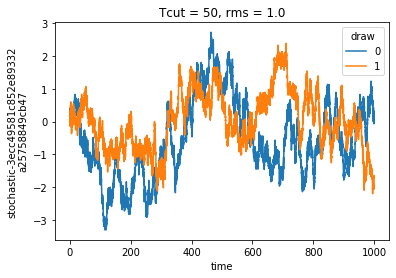

In [32]:
x = random_slow(1000, [10, 50, 100])
_ = x.sel(Tcut=50, draw=slice(1)).plot.line(x='time')

## check decorrelation length scale

In [38]:
def correlate_core(v1, v2, dt=None, roll=False, detrend=True, ufunc=True, **kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    assert v1.shape == v2.shape
    
    # below depends on x dimension order ... dangerous
    #if not ufunc:
    #    v1 = v1.transpose((2,1,0))
    #    v2 = v2.transpose((2,1,0))
    
    _correlate = np.correlate
    if detrend and not roll:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)
        #N = int(v1.shape[-1]/2)
    
    _kwargs = {'mode': 'same'}
    _kwargs.update(**kwargs)
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v1.shape[:-1]
    # infer number of lags from dummy computation
    i0 = tuple(0 for i in Ni) + np.s_[:,]
    f = _correlate(v1[i0], v2[i0], **_kwargs)
    vv = np.full(Ni+f.shape, np.NaN)
    for ii in np.ndindex(Ni):
        f = _correlate(v1[ii + np.s_[:,]], v2[ii + np.s_[:,]], **_kwargs)
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
    
    # select only positive lags
    vv = vv[...,int(vv.shape[-1]/2):]

    # normalized by number of points
    vv = vv/v1.shape[-1]
    
    if ufunc:
        return vv
    else:
        lags = np.arange(vv.shape[-1])*dt
        vv = vv.transpose((2,1,0))
        return lags, vv

def correlate(v1, v2, lags=None, **kwargs):
    v1 = v1.chunk({'time': -1})
    v2 = v2.chunk({'time': -1})
    dt = (v1.time[1]-v1.time[0]).values
    if lags is None:
        lags, C = correlate_core(v1.values, v2.values, dt=dt, ufunc=False, **kwargs)
        return lags, C
    else:
        C = xr.apply_ufunc(correlate_core, v1, v2,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time'], ['time']],
                    output_core_dims=[['lags']],
                    output_sizes={'lags': lags.size}, kwargs=kwargs)
        return C.assign_coords(lags=lags).rename('correlation')

In [57]:
small_x = x.isel(**{d: slice(0,2) for d in x.dims if d is not 'time'})
lags, _ = correlate(small_x, small_x, detrend=False)
xx = correlate(x, x, lags=lags, detrend=False).persist()
Cx = xx/xx.sel(lags=0)

Cx_qt = Cx.quantile([0.1, 0.9], ['draw']).persist()
Cx_mean = Cx.mean('draw').persist()

C_theorical = np.exp(-Cx.lags/Cx.Tcut)

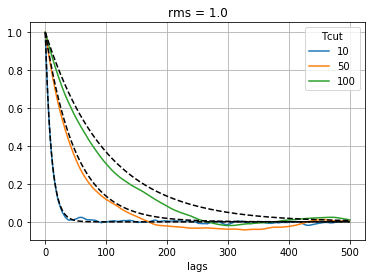

In [58]:
Cx_mean.plot.line(x='lags')
C_theorical.plot.line(x='lags', color='k', ls='--', add_legend=False)
plt.grid()

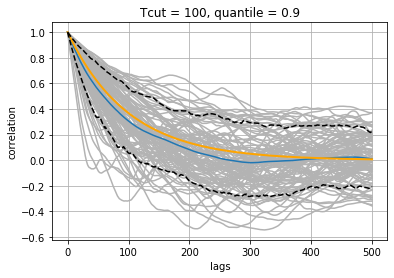

In [59]:
Tcut = 100

Cx.sel(Tcut=Tcut).plot.line(x='lags', color='0.7', add_legend=False)
Cx_mean.sel(Tcut=Tcut).plot.line(x='lags')
C_theorical.sel(Tcut=Tcut).plot.line(x='lags', color='orange', lw=2., add_legend=False)
Cx_qt.sel(quantile=0.1, Tcut=Tcut).plot.line(x='lags', color='k', ls='--')
Cx_qt.sel(quantile=0.9, Tcut=Tcut).plot.line(x='lags', color='k', ls='--')

plt.grid()

(array([ 4., 36., 91., 99., 39., 16., 10.,  3.,  1.,  1.]),
 array([0.22573144, 0.46073609, 0.69574075, 0.93074541, 1.16575006,
        1.40075472, 1.63575938, 1.87076403, 2.10576869, 2.34077334,
        2.575778  ]),
 <a list of 10 Patch objects>)

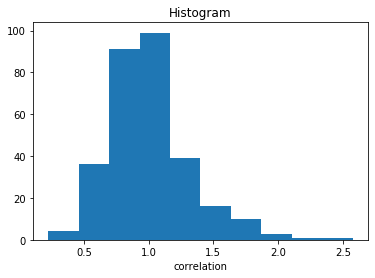

In [60]:
xx.sel(lags=0).plot.hist()

## check scaling for moving average and demodulation at a given frequency

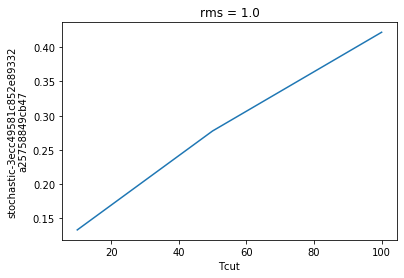

In [61]:
_ = x.mean('time').std('draw').plot()